In [33]:
import pandas as pd

In [9]:
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

In [35]:
# Import necessary libraries
import optuna
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# Load the dataset
df = pd.read_excel('E:\conference\FRACTIBILITY\Chapter5_Fracability_DataSet.xlsx')

df.head()

<>:10: SyntaxWarning:

invalid escape sequence '\c'

<>:10: SyntaxWarning:

invalid escape sequence '\c'

C:\Users\Asus\AppData\Local\Temp\ipykernel_10956\553379292.py:10: SyntaxWarning:

invalid escape sequence '\c'



,MD_ft,Resistivity,YM/PR,GR,Minimum Horizontal Stress Gradient,Fracability
0,13472.772070,466.626844,16.341279,481.414851,0.703538,1
1,9370.348405,577.253950,15.403192,324.750529,0.497242,0
2,10634.130671,439.087333,26.528042,265.034727,0.766302,0
3,18194.375034,309.679533,18.789840,169.480991,1.218154,1
4,18861.977710,614.959877,18.048478,480.189015,1.171049,1


In [36]:

df = pd.read_excel('E:\conference\FRACTIBILITY\Chapter5_Fracability_DataSet.xlsx')

df.head()
# selecting features and label
X = df.iloc[:, :-1]  # features
y = df.iloc[:,-1]  # label
X.shape, y.shape

# Split data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Optional: Scale the data for better model performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check the shape of the data
print(f'Training set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')


Training set shape: (700, 5)
Test set shape: (300, 5)


## XGBoost

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define the objective function
def objective(trial):
    # Suggest values for the hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_alpha = trial.suggest_float('reg_alpha', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0, 5)


    # Create the RandomForestClassifier with suggested hyperparameters
        model = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'  # Avoid warnings about the eval metric
        )
    # Perform 3-fold cross-validation and calculate accuracy
        score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

        return score  # Return the accuracy score for Optuna to maximize


In [38]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())  # We aim to maximize accuracy
study.optimize(objective, n_trials=50)  # Run 50 trials to find the best hyperparameters


[I 2024-12-07 16:27:55,961] A new study created in memory with name: no-name-a7ea81ee-2c18-4729-abe9-d8d09b15fd59
c:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[16:27:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[16:27:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[16:27:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\Asus\anaconda3\Lib\sit

In [39]:

# Print the best result
print(f'Best trial accuracy: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}')

Best trial accuracy: 0.9214285714285714
Best hyperparameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.015381338826105952, 'colsample_bytree': 0.626555587920667, 'gamma': 0.7934665089267359, 'reg_alpha': 3.437845558900819, 'reg_lambda': 4.629056110000228}


In [40]:
from sklearn.metrics import accuracy_score

# Train a RandomForestClassifier using the best hyperparameters from Optuna
best_model = XGBClassifier(**study.best_trial.params, random_state=42)

# Fit the model to the training data
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)

# Print the test accuracy
print(f'Test Accuracy with best hyperparameters: {test_accuracy:.2f}')


Test Accuracy with best hyperparameters: 0.95


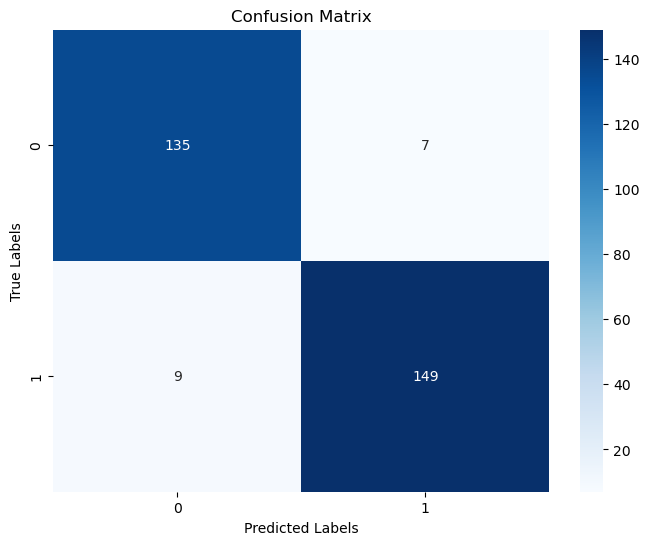

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_test and y_pred are defined
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate the classification report
class_report = classification_report(y_test, y_pred, output_dict=True)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("confusion_matrix_XG.png")  # Save plot as image
plt.show()

conf_matrix_df = pd.DataFrame(conf_matrix, columns=['Predicted_' + str(label) for label in set(y_test)], 
                              index=['Actual_' + str(label) for label in set(y_test)])
conf_matrix_df.to_csv("confusion_matrix_XG.csv", index=True)


# Save classification report as a CSV
class_report_df = pd.DataFrame(class_report).transpose()
class_report_df.to_csv("classification_report_XG.csv", index=True)


# GBoost

In [45]:
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# Define the objective function
def objective(trial):
    # Suggest values for the hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)


    # Create the RandomForestClassifier with suggested hyperparameters
        model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
    # Perform 3-fold cross-validation and calculate accuracy
        score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

        return score  # Return the accuracy score for Optuna to maximize

In [47]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())  # We aim to maximize accuracy
study.optimize(objective, n_trials=50)  # Run 50 trials to find the best hyperparameters


[I 2024-12-07 16:30:49,396] A new study created in memory with name: no-name-97b3bb1c-8f11-45e0-99a3-2007352747c1
[I 2024-12-07 16:30:54,682] Trial 0 finished with value: 0.9085714285714286 and parameters: {'n_estimators': 297, 'learning_rate': 0.17423798279877603, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9085714285714286.
[I 2024-12-07 16:31:01,304] Trial 1 finished with value: 0.8871428571428572 and parameters: {'n_estimators': 287, 'learning_rate': 0.09420431326731525, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9085714285714286.
[I 2024-12-07 16:31:13,704] Trial 2 finished with value: 0.9042857142857145 and parameters: {'n_estimators': 247, 'learning_rate': 0.022453107948215124, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9085714285714286.
[I 2024-12-07 16:31:16,188] Trial 3 finished with value: 0.9157142857142858 and parameters

In [48]:

# Print the best result
print(f'Best trial accuracy: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}')

Best trial accuracy: 0.9242857142857144
Best hyperparameters: {'n_estimators': 97, 'learning_rate': 0.2089971276140622, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 10}


In [49]:
from sklearn.metrics import accuracy_score

# Train a RandomForestClassifier using the best hyperparameters from Optuna
best_model = GradientBoostingClassifier(**study.best_trial.params, random_state=42)

# Fit the model to the training data
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)

# Print the test accuracy
print(f'Test Accuracy with best hyperparameters: {test_accuracy:.2f}')

Test Accuracy with best hyperparameters: 0.92


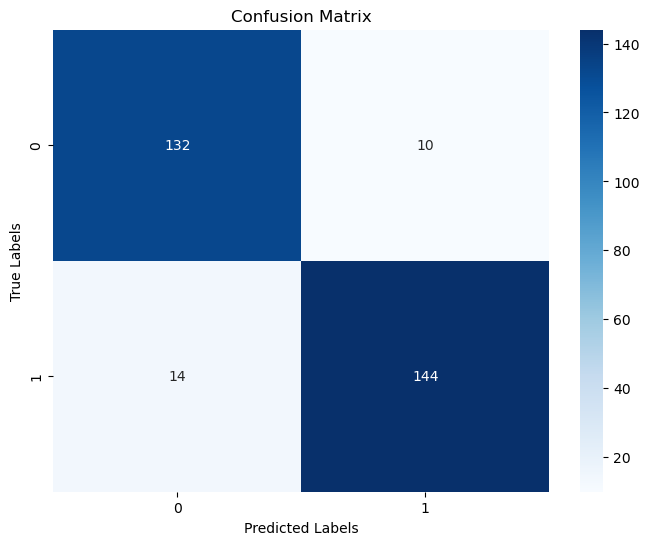

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_test and y_pred are defined
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate the classification report
class_report = classification_report(y_test, y_pred, output_dict=True)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("confusion_matrix_GB.png")  # Save plot as image
plt.show()

# Save confusion matrix as a CSV
conf_matrix_df = pd.DataFrame(conf_matrix, columns=['Predicted_' + str(label) for label in set(y_test)], 
                              index=['Actual_' + str(label) for label in set(y_test)])
conf_matrix_df.to_csv("confusion_matrix_Gb.csv", index=True)

# Save classification report as a CSV
class_report_df = pd.DataFrame(class_report).transpose()
class_report_df.to_csv("classification_report_GB.csv", index=True)



# ADAboost

In [51]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

# Define the objective function
def objective(trial):
    # Suggest values for the hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)

    # Create the RandomForestClassifier with suggested hyperparameters
        model = AdaBoostClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=42
        )
    # Perform 3-fold cross-validation and calculate accuracy
        score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

        return score  # Return the accuracy score for Optuna to maximize

In [52]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())  # We aim to maximize accuracy
study.optimize(objective, n_trials=50)  # Run 50 trials to find the best hyperparameters


[I 2024-12-07 16:34:45,533] A new study created in memory with name: no-name-a445ad8f-6672-4e66-ba78-c9ca28de0cbb
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME a

In [53]:

# Print the best result
print(f'Best trial accuracy: {study.best_trial.value}')
print(f'Best hyperparameters: {study.best_trial.params}')

Best trial accuracy: 0.9271428571428573
Best hyperparameters: {'n_estimators': 283, 'learning_rate': 0.15680005517936332}


In [54]:
from sklearn.metrics import accuracy_score

# Train a RandomForestClassifier using the best hyperparameters from Optuna
best_model =AdaBoostClassifier(**study.best_trial.params, random_state=42)

# Fit the model to the training data
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)

# Print the test accuracy
print(f'Test Accuracy with best hyperparameters: {test_accuracy:.2f}')

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



Test Accuracy with best hyperparameters: 0.95


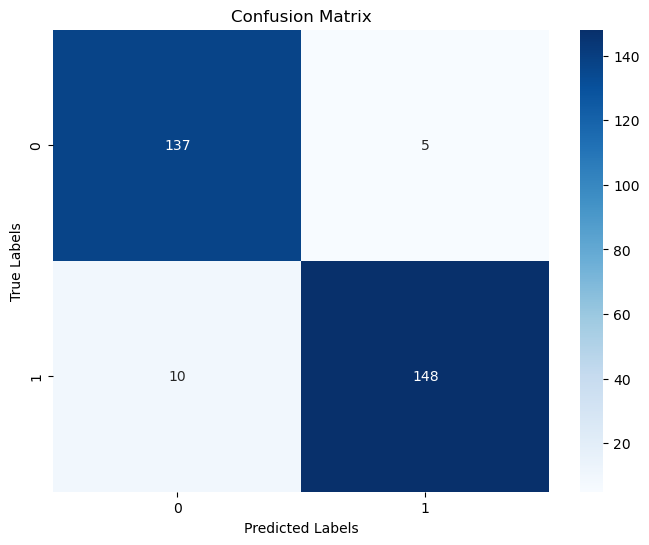

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_test and y_pred are defined
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate the classification report
class_report = classification_report(y_test, y_pred, output_dict=True)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("confusion_matrix_AB.png")  # Save plot as image
plt.show()

conf_matrix_df = pd.DataFrame(conf_matrix, columns=['Predicted_' + str(label) for label in set(y_test)], 
                              index=['Actual_' + str(label) for label in set(y_test)])
conf_matrix_df.to_csv("confusion_matrix_AB.csv", index=True)

# Save classification report as a CSV
class_report_df = pd.DataFrame(class_report).transpose()
class_report_df.to_csv("classification_report_AB.csv", index=True)


<>:16: SyntaxWarning: invalid escape sequence '\c'
<>:16: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Asus\AppData\Local\Temp\ipykernel_7320\419226497.py:16: SyntaxWarning: invalid escape sequence '\c'
  df = pd.read_excel('E:\conference\FRACTIBILITY\Chapter5_Fracability_DataSet.xlsx')
[I 2025-01-27 02:54:31,363] A new study created in memory with name: no-name-271bfb7a-1d22-446c-993c-98b902a0d621
c:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:54:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:54:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are 

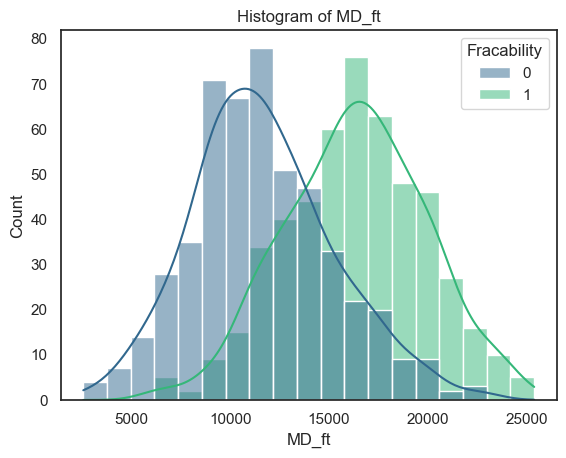

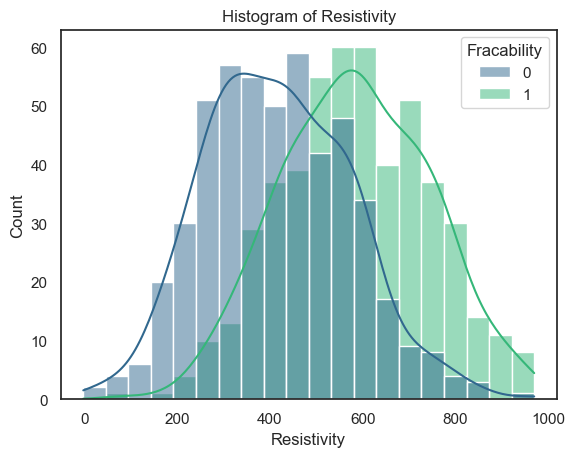

C:\Users\Asus\AppData\Local\Temp\ipykernel_7320\419226497.py:16: SyntaxWarning: invalid escape sequence '\c'
  df = pd.read_excel('E:\conference\FRACTIBILITY\Chapter5_Fracability_DataSet.xlsx')


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\conference\\FRACTIBILITY\\histogram_YM\\PR_2000dpi.png'

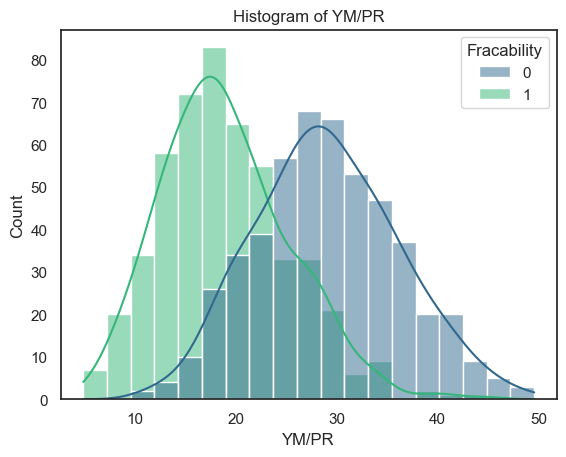

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, roc_curve,
                             auc, precision_recall_curve, classification_report)
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

# Load dataset
df = pd.read_excel('E:\conference\FRACTIBILITY\Chapter5_Fracability_DataSet.xlsx')

# Inspect the data
df.head()

# Selecting features and label
X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]  # Label (assuming the target column is the last one)

# Split data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the objective function for Optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define the objective function
def objective(trial):
    # Suggest values for the hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_alpha = trial.suggest_float('reg_alpha', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0, 5)


    # Create the RandomForestClassifier with suggested hyperparameters
        model = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'  # Avoid warnings about the eval metric
        )
    # Perform 3-fold cross-validation and calculate accuracy
        score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

        return score  # Return the accuracy score for Optuna to maximize
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50)

# Train the best model from Optuna
best_params = study.best_params
best_model = XGBClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]


# Histograms
for feature in X.columns:
    plt.figure()
    sns.histplot(data=df, x=feature, hue=df.columns[-1], kde=True, palette='viridis')
    plt.title(f"Histogram of {feature}")
    plt.savefig(f"histogram_{feature}_2000dpi.png", dpi=2000)  # Save each histogram
    plt.show()



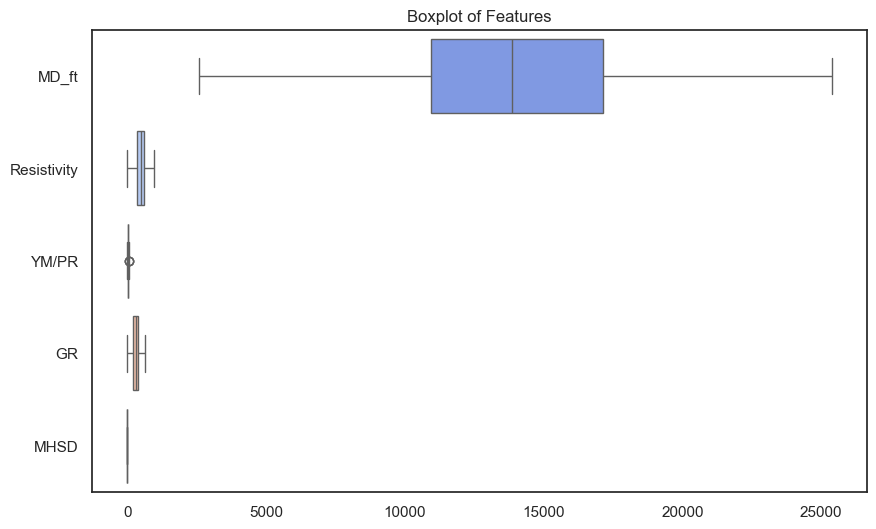

In [13]:
# Boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(data=df.iloc[:, :-1], orient="h", palette="coolwarm")
plt.title("Boxplot of Features")
plt.savefig("boxplot_2000dpi.png", dpi=2000)  # Save boxplot with 2000 dpi
plt.show()


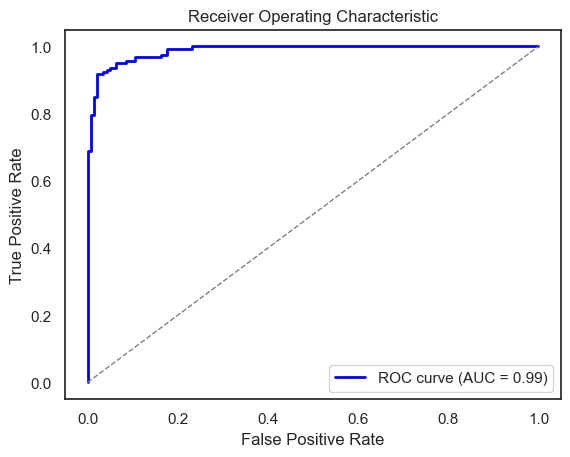

In [14]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.savefig("roc_curve_2000dpi.png", dpi=2000)  # Save ROC curve plot with 2000 dpi
plt.show()


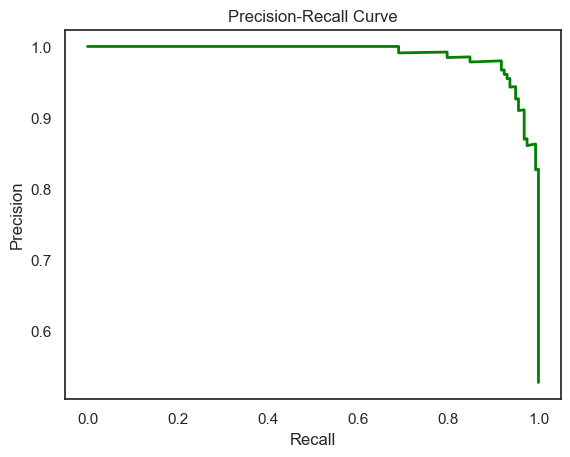

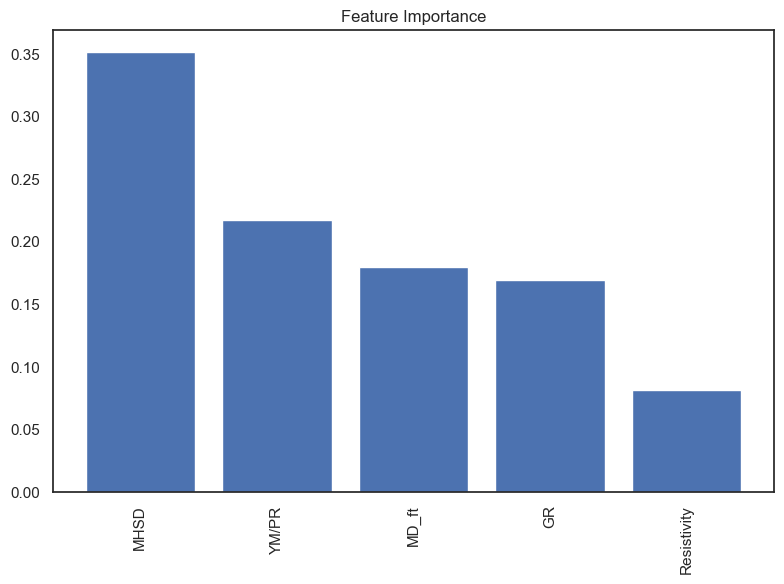

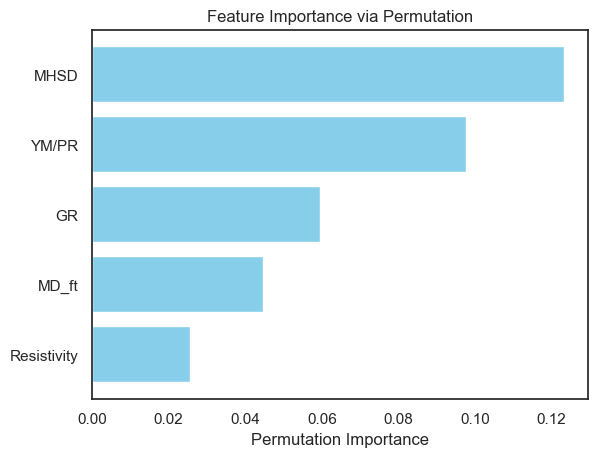

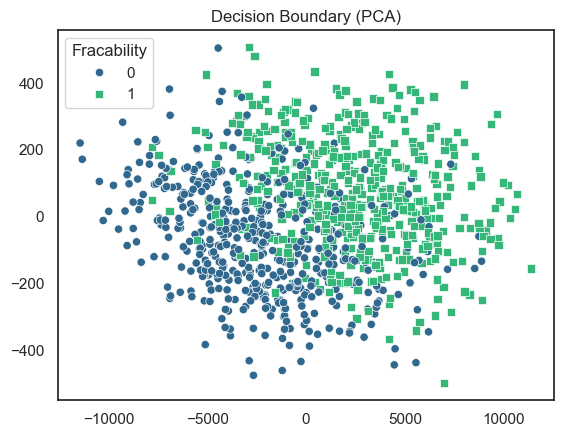

C:\Users\Asus\AppData\Local\Temp\ipykernel_7320\1188517605.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="viridis")


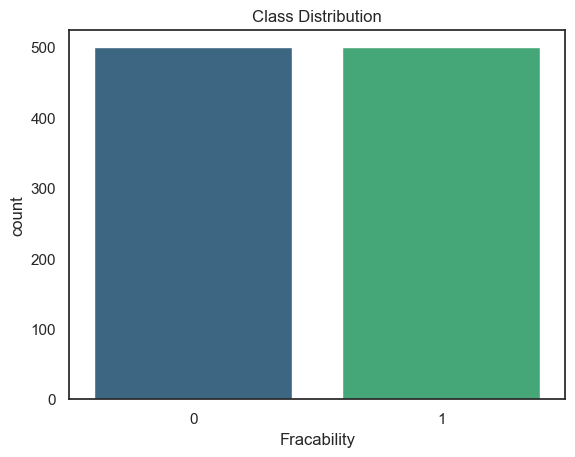

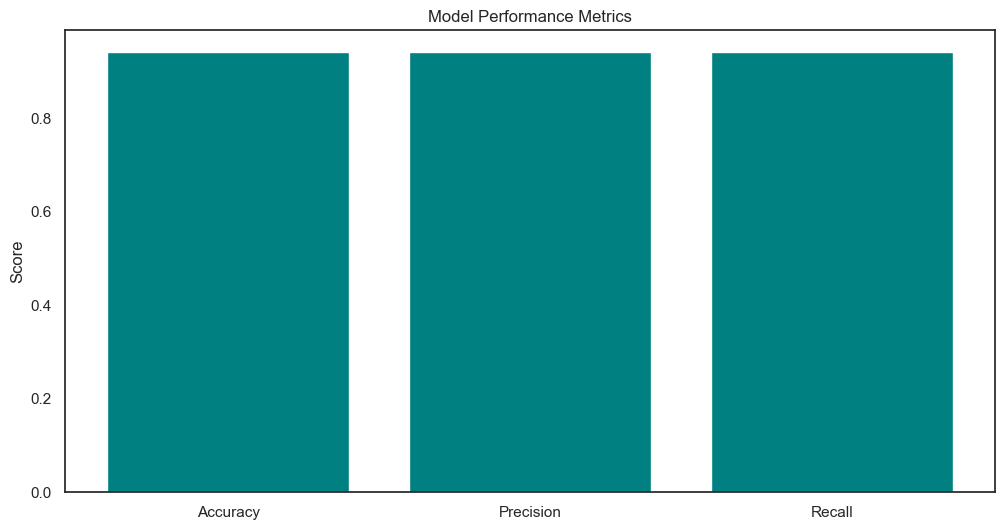

In [15]:

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.savefig("precision_recall_curve_2000dpi.png", dpi=2000)  # Save precision-recall curve plot with 2000 dpi
plt.show()

# Feature Importance
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.savefig("feature_importance_2000dpi.png", dpi=2000)  # Save feature importance plot with 2000 dpi
plt.show()

# Permutation Importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
perm_sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[perm_sorted_idx], perm_importance.importances_mean[perm_sorted_idx], color="skyblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance via Permutation")
plt.savefig("permutation_importance_2000dpi.png", dpi=2000)  # Save permutation importance plot with 2000 dpi
plt.show()

# Decision Boundary (using PCA to reduce to 2D)
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
x1, x2 = X_reduced[:, 0], X_reduced[:, 1]
plt.figure()
sns.scatterplot(x=x1, y=x2, hue=y, style=y, palette="viridis", markers=['o', 's'])
plt.title("Decision Boundary (PCA)")
plt.savefig("decision_boundary_2000dpi.png", dpi=2000)  # Save decision boundary plot with 2000 dpi
plt.show()

# Class Distribution
sns.countplot(x=y, palette="viridis")
plt.title("Class Distribution")
plt.savefig("class_distribution_2000dpi.png", dpi=2000)  # Save class distribution plot with 2000 dpi
plt.show()

# Pipeline Insights (Example)
report = classification_report(y_test, y_pred, output_dict=True)
metrics = {'Accuracy': report['accuracy'], 'Precision': report['weighted avg']['precision'], 'Recall': report['weighted avg']['recall']}
plt.figure(figsize=(12, 6))
plt.bar(metrics.keys(), metrics.values(), color="teal")
plt.ylabel("Score")
plt.title("Model Performance Metrics")
plt.savefig("model_performance_metrics_2000dpi.png", dpi=2000)  # Save model performance metrics plot with 2000 dpi
plt.show()

Correlation Matrix:
                MD_ft  Resistivity     YM/PR        GR      MHSD
MD_ft        1.000000     0.235255 -0.301018  0.330977  0.324981
Resistivity  0.235255     1.000000 -0.271908  0.246387  0.266242
YM/PR       -0.301018    -0.271908  1.000000 -0.323857 -0.324656
GR           0.330977     0.246387 -0.323857  1.000000  0.363736
MHSD         0.324981     0.266242 -0.324656  0.363736  1.000000


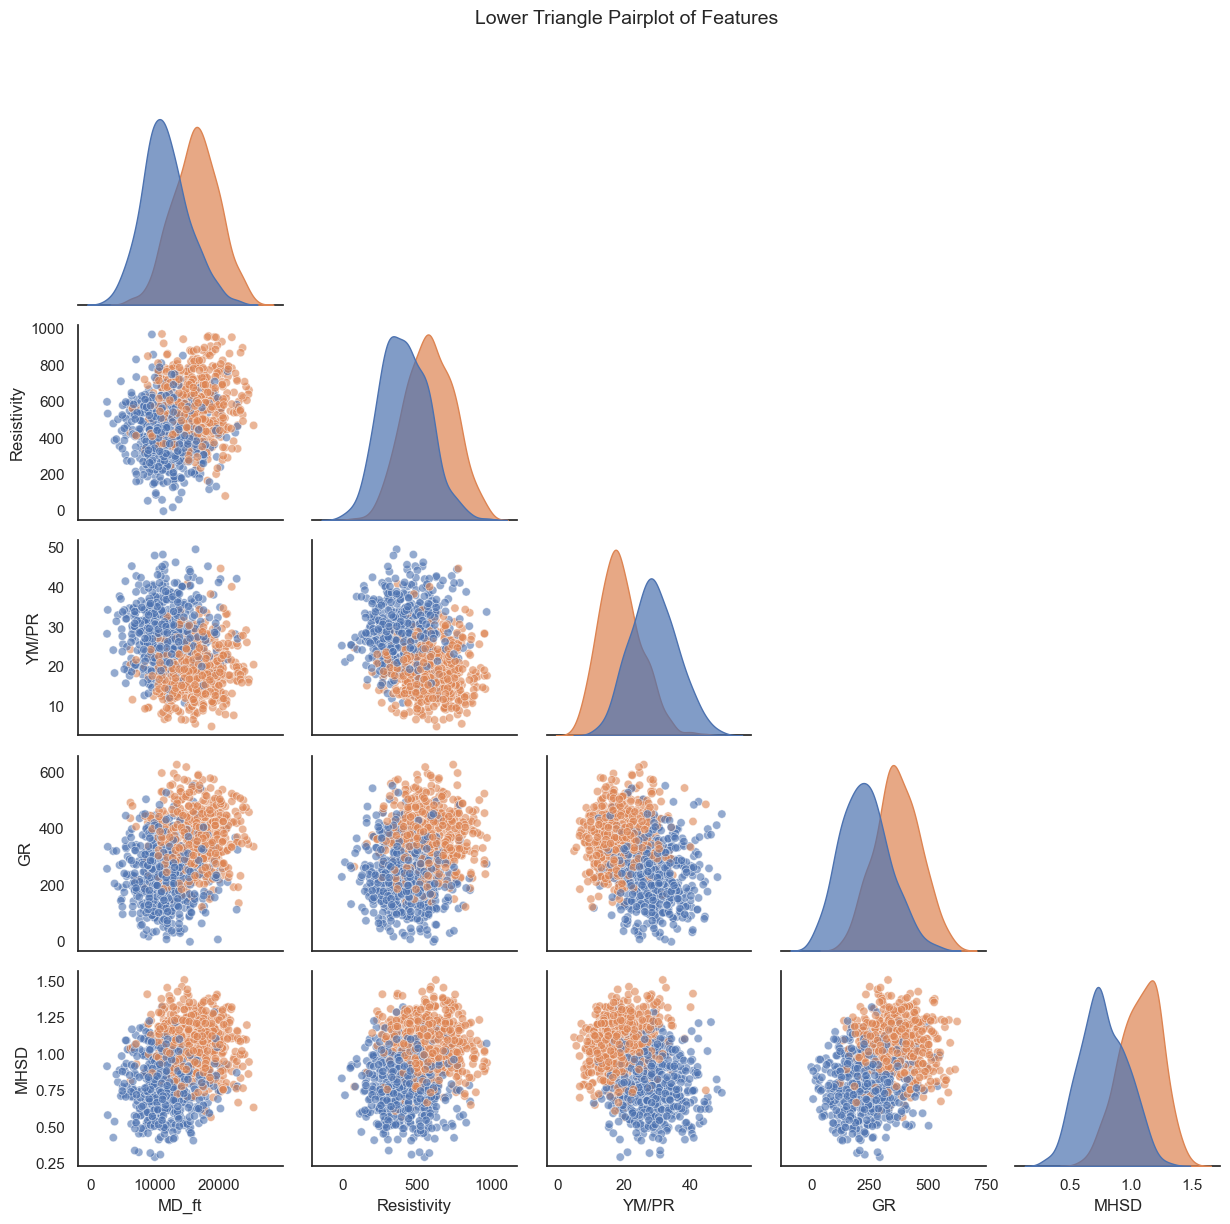

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_excel(r'E:\\conference\\FRACTIBILITY\\Chapter5_Fracability_DataSet.xlsx')

# Compute the correlation matrix for numerical features
correlation_matrix = df.iloc[:, :-1].corr()  # Exclude the target column for correlation
print("Correlation Matrix:")
print(correlation_matrix)

# Plot lower triangle of the pairplot
def lower_triangle_pairplot(data, hue):
    # Mask the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.set(style="white")
    
    # Create a custom PairGrid
    g = sns.PairGrid(data, hue=hue, diag_sharey=False, corner=True)
    
    # Define plot types for lower triangle, diagonal, and upper triangle
    g.map_lower(sns.scatterplot, alpha=0.6)
    g.map_diag(sns.kdeplot, fill=True, alpha=0.7)
    
    # Add titles and aesthetics
    g.fig.subplots_adjust(top=0.9)  # Adjust the title position
    g.fig.suptitle("Lower Triangle Pairplot of Features", fontsize=14)
    
    return g

# Generate the lower triangle pairplot
g = lower_triangle_pairplot(df, hue=df.columns[-1])  # Replace df.columns[-1] with target column name if necessary
g.savefig("lower_triangle_pairplot_2000dpi.png", dpi=2000)  # Save the plot with 2000 dpi
plt.show()


In [17]:
correlation_matrix = df.iloc[:, :-1].corr()  # Exclude the target column for correlation
print("Correlation Matrix:")
print(correlation_matrix)
correlation_matrix.to_csv('corr.csv')

Correlation Matrix:
                MD_ft  Resistivity     YM/PR        GR      MHSD
MD_ft        1.000000     0.235255 -0.301018  0.330977  0.324981
Resistivity  0.235255     1.000000 -0.271908  0.246387  0.266242
YM/PR       -0.301018    -0.271908  1.000000 -0.323857 -0.324656
GR           0.330977     0.246387 -0.323857  1.000000  0.363736
MHSD         0.324981     0.266242 -0.324656  0.363736  1.000000


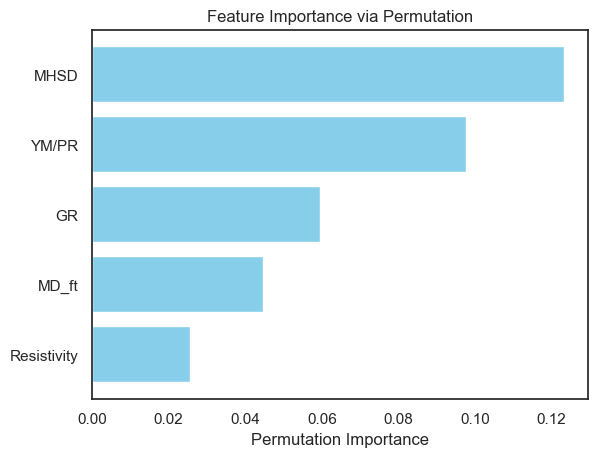

In [18]:
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
perm_sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[perm_sorted_idx], perm_importance.importances_mean[perm_sorted_idx], color="skyblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance via Permutation")
plt.savefig("permutation_importance_2000dpi.png", dpi=2000)  # Save permutation importance plot with 2000 dpi
plt.show()